### Method 1: Patch-level and Pixel-level NDVI drift analysis

Analyzing patch-level NDVI drift: 100%|██████████| 50/50 [00:00<00:00, 754.89it/s]


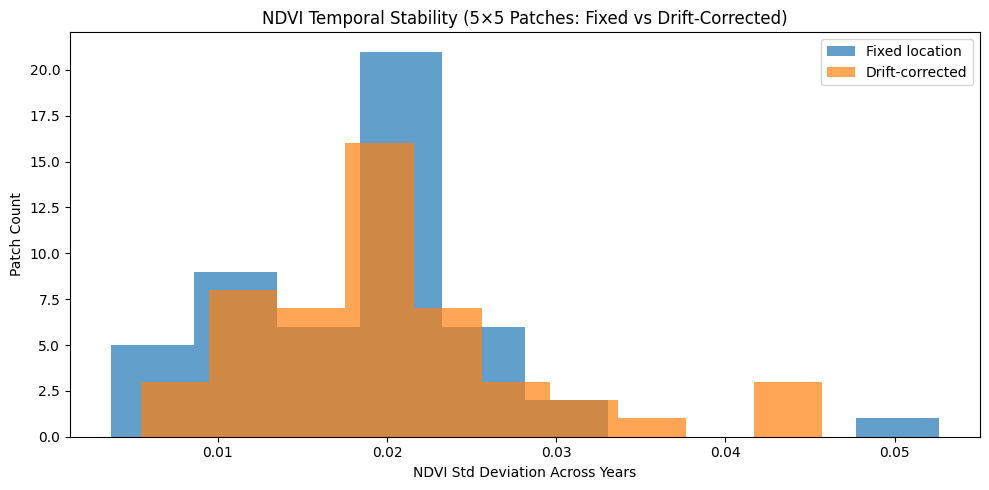


📊 Patch-Level NDVI Drift Comparison:
Mean std (Fixed): 0.01902
Mean std (Corrected): 0.02078
T-statistic: -1.5629
P-value: 0.124517


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import ttest_rel
import random

# === CONFIG ===
YEARS = [2014, 2016, 2018, 2020, 2022]
BASE_DIR = "preprocessed_output_{year}/matched_buffer_{year}.tif"
PATCH_SIZE = 5
RADIUS = PATCH_SIZE // 2
DRIFT_RANGE = 3
N_RANDOM = 47  # total patches = 3 fixed + 47 = 50

# === Manual fixed coords ===
FIXED_POINTS = [(119, 224), (121, 224), (118, 224)]

# === Load images into memory as float32 ===
def load_images():
    imgs = {}
    for year in YEARS:
        with rasterio.open(BASE_DIR.format(year=year)) as src:
            imgs[year] = src.read([1, 2, 3, 4]).astype(np.float32)  # RGBNIR
    return imgs

# === NDVI calculation ===
def compute_ndvi(red, nir):
    return (nir - red) / (nir + red + 1e-6)

def patch_ndvi(patch):
    red, nir = patch[0], patch[3]
    return compute_ndvi(red, nir)

# === Find best-matching patch (RGB-based) ===
def find_closest_patch(ref_patch, target_band, center, r=RADIUS, search=DRIFT_RANGE):
    min_mse, best_rc = float('inf'), center
    ref_rgb = ref_patch[:3]

    for dr in range(-search, search+1):
        for dc in range(-search, search+1):
            rr, cc = center[0]+dr, center[1]+dc
            if rr - r < 0 or rr + r + 1 > target_band.shape[1] or cc - r < 0 or cc + r + 1 > target_band.shape[2]:
                continue
            candidate = target_band[:3, rr-r:rr+r+1, cc-r:cc+r+1]
            mse = np.mean((ref_rgb - candidate)**2)
            if mse < min_mse:
                min_mse = mse
                best_rc = (rr, cc)
    return best_rc

# === Main analysis ===
def analyze(images, fixed_coords):
    shape = images[YEARS[0]].shape[1:]
    coords = list(fixed_coords)

    # Add random samples
    while len(coords) < len(fixed_coords) + N_RANDOM:
        r = random.randint(RADIUS + DRIFT_RANGE, shape[0] - RADIUS - DRIFT_RANGE - 1)
        c = random.randint(RADIUS + DRIFT_RANGE, shape[1] - RADIUS - DRIFT_RANGE - 1)
        if (r, c) not in coords:
            coords.append((r, c))

    fixed_std_list = []
    drift_std_list = []

    for row, col in tqdm(coords, desc="Analyzing patch-level NDVI drift"):
        fixed_ndvis, drift_ndvis = [], []

        ref_patch = images[2014][:, row-RADIUS:row+RADIUS+1, col-RADIUS:col+RADIUS+1]
        for year in YEARS:
            band = images[year]

            # Fixed
            patch = band[:, row-RADIUS:row+RADIUS+1, col-RADIUS:col+RADIUS+1]
            ndvi = patch_ndvi(patch).mean()
            fixed_ndvis.append(ndvi)

            # Drift-corrected
            best_r, best_c = find_closest_patch(ref_patch, band, (row, col))
            drift_patch = band[:, best_r-RADIUS:best_r+RADIUS+1, best_c-RADIUS:best_c+RADIUS+1]
            drift_ndvi = patch_ndvi(drift_patch).mean()
            drift_ndvis.append(drift_ndvi)

        fixed_std_list.append(np.std(fixed_ndvis))
        drift_std_list.append(np.std(drift_ndvis))

    return fixed_std_list, drift_std_list

# === Plot and stats ===
def plot_results(fixed, drift):
    plt.figure(figsize=(10, 5))
    plt.hist(fixed, bins=10, alpha=0.7, label="Fixed location")
    plt.hist(drift, bins=10, alpha=0.7, label="Drift-corrected")
    plt.xlabel("NDVI Std Deviation Across Years")
    plt.ylabel("Patch Count")
    plt.title("NDVI Temporal Stability (5×5 Patches: Fixed vs Drift-Corrected)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    tstat, pval = ttest_rel(fixed, drift)
    print(f"\n📊 Patch-Level NDVI Drift Comparison:")
    print(f"Mean std (Fixed): {np.mean(fixed):.5f}")
    print(f"Mean std (Corrected): {np.mean(drift):.5f}")
    print(f"T-statistic: {tstat:.4f}")
    print(f"P-value: {pval:.6f}")

# === Run ===
images = load_images()
fixed_std, drift_std = analyze(images, FIXED_POINTS)
plot_results(fixed_std, drift_std)

Analyzing pixel-level NDVI drift: 100%|██████████| 50/50 [00:00<00:00, 1832.37it/s]


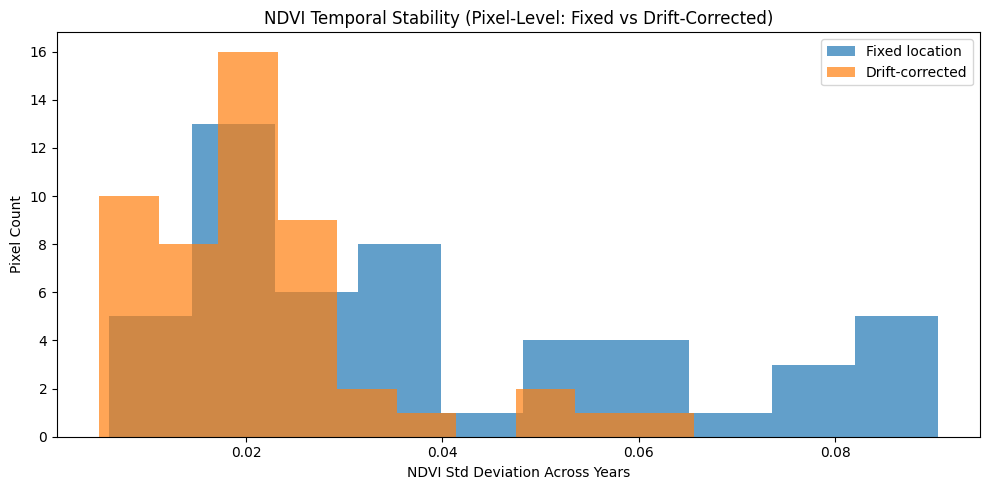


📊 Pixel-Level NDVI Drift Comparison:
Mean std (Fixed): 0.03982
Mean std (Corrected): 0.02163
T-statistic: 5.4654
P-value: 0.000002


In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import ttest_rel
import random

# === CONFIG ===
YEARS = [2014, 2016, 2018, 2020, 2022]
BASE_DIR = "preprocessed_output_{year}/matched_buffer_{year}.tif"
DRIFT_RANGE = 3
N_RANDOM = 47
FIXED_POINTS = [(119, 224), (121, 224), (118, 224)]  # manually inserted

# === Load images into memory ===
def load_images():
    imgs = {}
    for year in YEARS:
        with rasterio.open(BASE_DIR.format(year=year)) as src:
            imgs[year] = src.read([1, 2, 3, 4]).astype(np.float32)
    return imgs

def compute_ndvi(red, nir):
    return (nir - red) / (nir + red + 1e-6)

def extract_ndvi_pixel(img, r, c):
    red, nir = img[0, r, c], img[3, r, c]
    return compute_ndvi(red, nir)

def find_drifted_pixel(ref_pixel, tgt_img, r0, c0, search=DRIFT_RANGE):
    min_dist = float("inf")
    best_r, best_c = r0, c0
    for dr in range(-search, search + 1):
        for dc in range(-search, search + 1):
            rr, cc = r0 + dr, c0 + dc
            if 0 <= rr < tgt_img.shape[1] and 0 <= cc < tgt_img.shape[2]:
                tgt_vec = tgt_img[:4, rr, cc]
                dist = np.linalg.norm(ref_pixel - tgt_vec)
                if dist < min_dist:
                    min_dist = dist
                    best_r, best_c = rr, cc
    return best_r, best_c

# === Main analysis ===
def analyze(images, fixed_coords):
    shape = images[YEARS[0]].shape[1:]
    coords = list(fixed_coords)

    # Add same number of random points
    while len(coords) < len(fixed_coords) + N_RANDOM:
        r = random.randint(10, shape[0] - 10)
        c = random.randint(10, shape[1] - 10)
        if (r, c) not in coords:
            coords.append((r, c))

    fixed_std_list = []
    drift_std_list = []

    for row, col in tqdm(coords, desc="Analyzing pixel-level NDVI drift"):
        fixed_ndvis, drift_ndvis = [], []
        ref_img = images[2014]
        ref_vec = ref_img[:4, row, col]

        for year in YEARS:
            img = images[year]

            # Fixed
            fixed_ndvis.append(extract_ndvi_pixel(img, row, col))

            # Drift-corrected
            if year == 2014:
                drift_ndvis.append(fixed_ndvis[-1])
            else:
                best_r, best_c = find_drifted_pixel(ref_vec, img, row, col)
                drift_ndvis.append(extract_ndvi_pixel(img, best_r, best_c))

        fixed_std_list.append(np.std(fixed_ndvis))
        drift_std_list.append(np.std(drift_ndvis))

    return fixed_std_list, drift_std_list

# === Plot and stats ===
def plot_results(fixed, drift):
    plt.figure(figsize=(10, 5))
    plt.hist(fixed, bins=10, alpha=0.7, label="Fixed location")
    plt.hist(drift, bins=10, alpha=0.7, label="Drift-corrected")
    plt.xlabel("NDVI Std Deviation Across Years")
    plt.ylabel("Pixel Count")
    plt.title("NDVI Temporal Stability (Pixel-Level: Fixed vs Drift-Corrected)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    tstat, pval = ttest_rel(fixed, drift)
    print(f"\n📊 Pixel-Level NDVI Drift Comparison:")
    print(f"Mean std (Fixed): {np.mean(fixed):.5f}")
    print(f"Mean std (Corrected): {np.mean(drift):.5f}")
    print(f"T-statistic: {tstat:.4f}")
    print(f"P-value: {pval:.6f}")

# === Run ===
images = load_images()
fixed_std, drift_std = analyze(images, FIXED_POINTS)
plot_results(fixed_std, drift_std)

### Method 2

In [10]:
random.seed(42)

Analyzing transitions: 100%|██████████| 2000/2000 [00:00<00:00, 205316.30it/s]


Analyzing transitions: 100%|██████████| 2000/2000 [00:01<00:00, 1511.33it/s]


🚨 Implausible Transitions Summary:
Fixed   → 1178 / 8000 (14.72%)
Corrected → 759 / 8000 (9.49%)


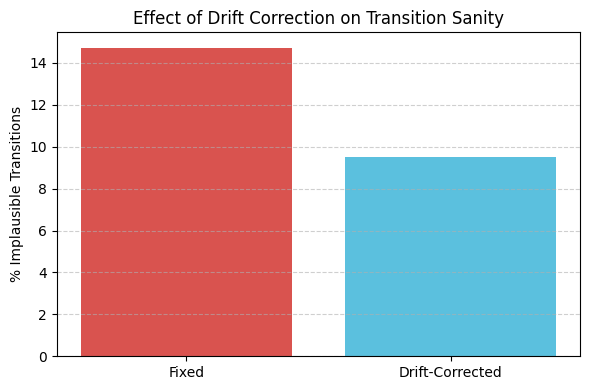

In [11]:
import rasterio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

# === CONFIG ===
YEARS = [2014, 2016, 2018, 2020, 2022]
YEAR_STRS = [str(y) for y in YEARS]
RASTER_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
SAMPLES = 2000
DRIFT_RANGE = 3  # search radius for drift correction
PATCH_SIZE = 5
RADIUS = PATCH_SIZE // 2

# === Define implausible transitions
IMPLAUSIBLE = set([
    (2, 0),  # BARE → LIVE
    (1, 0),  # DEAD → LIVE
    (2, 1),  # BARE → DEAD
])

# === Load all rasters
rasters = {}
for year in YEARS:
    with rasterio.open(RASTER_PATH.format(year=year)) as src:
        rasters[year] = src.read(1)

height, width = rasters[2014].shape

# === Utility: get best-match location (RGB MSE)
def best_match_location(ref_patch, target, r, c):
    min_mse = float("inf")
    best = (r, c)
    for dr in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
        for dc in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
            rr, cc = r + dr, c + dc
            if rr - RADIUS < 0 or rr + RADIUS + 1 > height:
                continue
            if cc - RADIUS < 0 or cc + RADIUS + 1 > width:
                continue
            candidate = target[rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
            mse = np.mean((candidate - ref_patch) ** 2)
            if mse < min_mse:
                min_mse = mse
                best = (rr, cc)
    return best

# === Count implausible transitions
def count_implausible(rasters, corrected=False):
    count = 0
    total = 0

    for _ in tqdm(range(SAMPLES), desc="Analyzing transitions"):
        r = np.random.randint(RADIUS + DRIFT_RANGE, height - RADIUS - DRIFT_RANGE)
        c = np.random.randint(RADIUS + DRIFT_RANGE, width - RADIUS - DRIFT_RANGE)

        classes = []
        if corrected:
            ref_patch = rasters[2014][r - RADIUS:r + RADIUS + 1, c - RADIUS:c + RADIUS + 1]
            ref_r, ref_c = r, c
            for year in YEARS:
                if year == 2014:
                    classes.append(rasters[year][r, c])
                else:
                    band = rasters[year]
                    rr, cc = best_match_location(ref_patch, band, ref_r, ref_c)
                    classes.append(band[rr, cc])
        else:
            for year in YEARS:
                classes.append(rasters[year][r, c])

        # Check pairwise transitions
        for i in range(len(classes) - 1):
            trans = (classes[i], classes[i + 1])
            total += 1
            if trans in IMPLAUSIBLE:
                count += 1

    return count, total

# === Run both variants
fixed_count, fixed_total = count_implausible(rasters, corrected=False)
drift_count, drift_total = count_implausible(rasters, corrected=True)

# === Results
fixed_pct = 100 * fixed_count / fixed_total
drift_pct = 100 * drift_count / drift_total

print("\n🚨 Implausible Transitions Summary:")
print(f"Fixed   → {fixed_count} / {fixed_total} ({fixed_pct:.2f}%)")
print(f"Corrected → {drift_count} / {drift_total} ({drift_pct:.2f}%)")

# === Bar chart
plt.figure(figsize=(6, 4))
plt.bar(["Fixed", "Drift-Corrected"], [fixed_pct, drift_pct], color=["#d9534f", "#5bc0de"])
plt.ylabel("% Implausible Transitions")
plt.title("Effect of Drift Correction on Transition Sanity")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [12]:
import numpy as np
import rasterio
import random
from collections import Counter
import matplotlib.pyplot as plt

# === CONFIG ===
DRIFT_COORDS = {
    2014: (119, 224),
    2016: (121, 224),
    2018: (118, 224)
}
YEARS = [2014, 2016, 2018]
RASTER_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
N_SAMPLES = 1000
RADIUS = 20
NODATA = 255

# === Define implausible transitions ===
def is_implausible(seq):
    if NODATA in seq:
        return False  # skip incomplete sequences
    # LIVE=0, DEAD=1, BARE=2
    if seq[0] == 2 and seq[1] == 1: return True  # BARE -> DEAD
    if seq[0] == 2 and seq[2] == 0: return True  # BARE -> LIVE
    if seq[0] == 1 and seq[2] == 0: return True  # DEAD -> LIVE
    return False

# === Load predicted class rasters ===
def load_predictions():
    preds = {}
    for year in YEARS:
        with rasterio.open(RASTER_PATH.format(year=year)) as src:
            preds[year] = src.read(1)
    return preds

# === Sample N random points around drift-aligned centers ===
def sample_points(center, count, radius, shape):
    points = []
    for _ in range(count):
        while True:
            dr = random.randint(-radius, radius)
            dc = random.randint(-radius, radius)
            r, c = center[0] + dr, center[1] + dc
            if 0 <= r < shape[0] and 0 <= c < shape[1]:
                points.append((r, c))
                break
    return points

# === Main Evaluation ===
def evaluate_drift_aligned_transitions():
    preds = load_predictions()
    shape = preds[2014].shape
    center = DRIFT_COORDS[2014]  # base center for sampling
    sampled = sample_points(center, N_SAMPLES, RADIUS, shape)

    fixed_implausible = 0
    corrected_implausible = 0

    for r, c in sampled:
        # Fixed sampling (same coord across years)
        fixed_seq = [preds[y][r, c] for y in YEARS]
        if is_implausible(fixed_seq):
            fixed_implausible += 1

        # Drift-aware sampling using known shifts
        drift_seq = [preds[y][DRIFT_COORDS[y][0] + (r - center[0]),
                             DRIFT_COORDS[y][1] + (c - center[1])]
                     for y in YEARS]
        if is_implausible(drift_seq):
            corrected_implausible += 1

    return fixed_implausible, corrected_implausible, N_SAMPLES

# === Run ===
fixed, corrected, total = evaluate_drift_aligned_transitions()
print("🚨 Implausible Transitions Summary:")
print(f"Fixed     → {fixed} / {total} ({fixed / total * 100:.2f}%)")
print(f"Corrected → {corrected} / {total} ({corrected / total * 100:.2f}%)")

🚨 Implausible Transitions Summary:
Fixed     → 167 / 1000 (16.70%)
Corrected → 241 / 1000 (24.10%)


In [18]:
import rasterio
import numpy as np
import random
from tqdm import tqdm

# === CONFIG ===
random.seed(42)
YEARS = [2014, 2016, 2018]
RASTER_PATH = "preprocessed_output_{year}/matched_buffer_{year}.tif"
PRED_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
SAMPLES = 1000
PATCH_RADIUS = 1  # 3x3 search
IMG_BANDS = [1, 2, 3, 4]  # RGBNIR

# === Load predicted rasters ===
def load_predictions():
    preds = {}
    for year in YEARS:
        with rasterio.open(PRED_PATH.format(year=year)) as src:
            preds[year] = src.read(1)
    return preds

# === Load RGBNIR images ===
def load_images():
    imgs = {}
    for year in YEARS:
        with rasterio.open(RASTER_PATH.format(year=year)) as src:
            imgs[year] = src.read(IMG_BANDS)
    return imgs

# === Find closest spectral match in a window ===
def find_best_match(ref_pixel, tgt_img, row, col):
    h, w = tgt_img.shape[1:]
    best_dist = float("inf")
    best_loc = (row, col)

    for dr in range(-PATCH_RADIUS, PATCH_RADIUS + 1):
        for dc in range(-PATCH_RADIUS, PATCH_RADIUS + 1):
            rr, cc = row + dr, col + dc
            if rr < 0 or rr >= h or cc < 0 or cc >= w:
                continue
            tgt_pixel = tgt_img[:, rr, cc]
            dist = np.linalg.norm(ref_pixel - tgt_pixel)
            if dist < best_dist:
                best_dist = dist
                best_loc = (rr, cc)

    return best_loc

# === Check if transition is implausible ===
def is_implausible(prev, curr):
    # 0 = LIVE, 1 = DEAD, 2 = BARE
    return (prev == 2 and curr == 0) or (prev == 1 and curr == 0)

# === Main analysis ===
def analyze_transitions(preds, imgs):
    h, w = preds[2014].shape
    fixed_bad, corrected_bad = 0, 0

    for _ in tqdm(range(SAMPLES), desc="Analyzing transitions"):
        row = random.randint(5, h - 6)
        col = random.randint(5, w - 6)

        # === Fixed transition check
        seq = [preds[year][row, col] for year in YEARS]
        for i in range(len(seq) - 1):
            if is_implausible(seq[i], seq[i + 1]):
                fixed_bad += 1
                break

        # === Drift-corrected transition check
        r, c = row, col
        seq_corr = [preds[YEARS[0]][r, c]]

        for i in range(len(YEARS) - 1):
            y1, y2 = YEARS[i], YEARS[i + 1]
            ref_vec = imgs[y1][:, r, c]
            tgt_img = imgs[y2]

            r, c = find_best_match(ref_vec, tgt_img, r, c)
            seq_corr.append(preds[y2][r, c])

        for i in range(len(seq_corr) - 1):
            if is_implausible(seq_corr[i], seq_corr[i + 1]):
                corrected_bad += 1
                break

    return fixed_bad, corrected_bad

# === Run ===
preds = load_predictions()
imgs = load_images()

fixed, corrected = analyze_transitions(preds, imgs)

print(f"\n🚨 Implausible Transitions Summary:")
print(f"Fixed     → {fixed} / {SAMPLES} ({fixed/SAMPLES:.2%})")
print(f"Corrected → {corrected} / {SAMPLES} ({corrected/SAMPLES:.2%})")

Analyzing transitions: 100%|██████████| 1000/1000 [00:00<00:00, 17648.49it/s]


🚨 Implausible Transitions Summary:
Fixed     → 138 / 1000 (13.80%)
Corrected → 153 / 1000 (15.30%)


In [23]:
import rasterio
import numpy as np
import random
from tqdm import tqdm

# --- Config ---
random.seed(42)
YEARS = [2014, 2016, 2018]
RASTER_PATH = "preprocessed_output_{year}/matched_buffer_{year}.tif"
PRED_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
SAMPLES = 1000
PATCH_SIZE = 5
RADIUS = PATCH_SIZE // 2
DRIFT_RANGE = 2  # 5×5 search area

# Implausible transitions
IMPLAUSIBLE = {
    (2, 1),  # BARE → DEAD
    (2, 0),  # BARE → LIVE
    (1, 0),  # DEAD → LIVE
}

# --- Load predicted class maps ---
class_maps = {}
for year in YEARS:
    with rasterio.open(PRED_PATH.format(year=year)) as src:
        class_maps[year] = src.read(1)

# --- Load RGBNIR imagery for drift matching ---
rgbnir_maps = {}
for year in YEARS:
    with rasterio.open(RASTER_PATH.format(year=year)) as src:
        rgbnir_maps[year] = src.read([1, 2, 3, 4])

height, width = class_maps[YEARS[0]].shape

# --- Sample valid locations ---
mask = (class_maps[YEARS[0]] <= 2)
pixels = []
while len(pixels) < SAMPLES:
    r = random.randint(RADIUS + DRIFT_RANGE, height - RADIUS - DRIFT_RANGE - 1)
    c = random.randint(RADIUS + DRIFT_RANGE, width - RADIUS - DRIFT_RANGE - 1)
    if mask[r, c]:
        pixels.append((r, c))

# --- Helper: MSE drift matcher on RGB only ---
def best_match(ref_patch, tgt_rgb, r, c):
    min_mse, best_loc = float('inf'), (r, c)
    ref_rgb = ref_patch[:3]
    for dr in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
        for dc in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
            rr, cc = r + dr, c + dc
            if rr - RADIUS < 0 or rr + RADIUS + 1 > height or cc - RADIUS < 0 or cc + RADIUS + 1 > width:
                continue
            candidate = tgt_rgb[:3, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
            mse = np.mean((ref_rgb - candidate) ** 2)
            if mse < min_mse:
                min_mse = mse
                best_loc = (rr, cc)
    return best_loc

# --- Run transition analysis ---
implausible_fixed = 0
implausible_corrected = 0

for r, c in tqdm(pixels, desc="Analyzing transitions"):
    # Fixed sequence
    fixed_seq = [class_maps[year][r, c] for year in YEARS]

    # Corrected sequence
    corrected_seq = [class_maps[YEARS[0]][r, c]]
    rr, cc = r, c
    for i in range(len(YEARS) - 1):
        ref_patch = rgbnir_maps[YEARS[i]][:, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
        tgt_rgb = rgbnir_maps[YEARS[i + 1]]
        rr, cc = best_match(ref_patch, tgt_rgb, rr, cc)
        corrected_seq.append(class_maps[YEARS[i + 1]][rr, cc])

    # Count implausible transitions
    for a, b in zip(fixed_seq[:-1], fixed_seq[1:]):
        if (a, b) in IMPLAUSIBLE:
            implausible_fixed += 1

    for a, b in zip(corrected_seq[:-1], corrected_seq[1:]):
        if (a, b) in IMPLAUSIBLE:
            implausible_corrected += 1

# --- Report ---
print("\n🚨 Implausible Transitions Summary:")
print(f"Fixed     → {implausible_fixed} / {SAMPLES} ({100 * implausible_fixed / SAMPLES:.2f}%)")
print(f"Corrected → {implausible_corrected} / {SAMPLES} ({100 * implausible_corrected / SAMPLES:.2f}%)")

Analyzing transitions: 100%|██████████| 1000/1000 [00:00<00:00, 5345.25it/s]


🚨 Implausible Transitions Summary:
Fixed     → 353 / 1000 (35.30%)
Corrected → 278 / 1000 (27.80%)


In [1]:
import rasterio
import numpy as np
import random
from collections import Counter, defaultdict
from tqdm import tqdm

# --- CONFIG ---
random.seed(42)
YEARS = [2014, 2016, 2018, 2020, 2022]
RASTER_PATH = "preprocessed_output_{year}/matched_buffer_{year}.tif"
PRED_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
SAMPLES = 1000
PATCH_SIZE = 5
RADIUS = PATCH_SIZE // 2
DRIFT_RANGE = 2  # 5x5 search window

# --- Load predicted class maps ---
class_maps = {year: rasterio.open(PRED_PATH.format(year=year)).read(1) for year in YEARS}

# --- Load RGBNIR imagery for drift matching ---
rgbnir_maps = {year: rasterio.open(RASTER_PATH.format(year=year)).read([1, 2, 3, 4]) for year in YEARS}
height, width = class_maps[YEARS[0]].shape

# --- Sample valid pixels ---
mask = (class_maps[YEARS[0]] <= 2)
pixels = []
while len(pixels) < SAMPLES:
    r = random.randint(RADIUS + DRIFT_RANGE, height - RADIUS - DRIFT_RANGE - 1)
    c = random.randint(RADIUS + DRIFT_RANGE, width - RADIUS - DRIFT_RANGE - 1)
    if mask[r, c]:
        pixels.append((r, c))

# --- Helper: MSE patch match (RGB only) ---
def best_patch_match(ref_patch, tgt_img, r, c):
    best_score, best_loc = float('inf'), (r, c)
    ref_rgb = ref_patch[:3]
    for dr in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
        for dc in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
            rr, cc = r + dr, c + dc
            if rr - RADIUS < 0 or rr + RADIUS + 1 > height or cc - RADIUS < 0 or cc + RADIUS + 1 > width:
                continue
            candidate = tgt_img[:3, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
            mse = np.mean((ref_rgb - candidate) ** 2)
            if mse < best_score:
                best_score = mse
                best_loc = (rr, cc)
    return best_loc

# --- Analyze transitions ---
fixed_transitions = Counter()
corrected_transitions = Counter()

for r, c in tqdm(pixels, desc="Tracking patch transitions"):
    # Fixed
    seq_fixed = [class_maps[y][r, c] for y in YEARS]
    for a, b in zip(seq_fixed[:-1], seq_fixed[1:]):
        fixed_transitions[(a, b)] += 1

    # Drift-corrected
    rr, cc = r, c
    seq_corr = [class_maps[YEARS[0]][rr, cc]]
    for i in range(len(YEARS) - 1):
        y1, y2 = YEARS[i], YEARS[i + 1]
        ref_patch = rgbnir_maps[y1][:, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
        tgt_img = rgbnir_maps[y2]
        rr, cc = best_patch_match(ref_patch, tgt_img, rr, cc)
        seq_corr.append(class_maps[y2][rr, cc])
    for a, b in zip(seq_corr[:-1], seq_corr[1:]):
        corrected_transitions[(a, b)] += 1

# --- Print transition tables ---
def print_transition_table(counter, label):
    print(f"\n📊 Transition Table ({label}):")
    print("From → To | Count")
    print("----------------------")
    for (a, b), count in sorted(counter.items()):
        print(f"   {a}  →  {b} | {count}")

print_transition_table(fixed_transitions, "Fixed")
print_transition_table(corrected_transitions, "Drift-Corrected")

Tracking patch transitions: 100%|██████████| 1000/1000 [00:00<00:00, 2696.76it/s]


📊 Transition Table (Fixed):
From → To | Count
----------------------
   0  →  0 | 281
   0  →  1 | 229
   0  →  2 | 75
   1  →  0 | 266
   1  →  1 | 503
   1  →  2 | 363
   2  →  0 | 70
   2  →  1 | 363
   2  →  2 | 1850

📊 Transition Table (Drift-Corrected):
From → To | Count
----------------------
   0  →  0 | 414
   0  →  1 | 161
   0  →  2 | 30
   1  →  0 | 195
   1  →  1 | 647
   1  →  2 | 264
   2  →  0 | 26
   2  →  1 | 254
   2  →  2 | 2009


In [3]:
import rasterio
import numpy as np
import random
from tqdm import tqdm
from collections import Counter
from scipy.stats import mode

# --- Config ---
random.seed(42)
YEARS = [2014, 2016, 2018]
RASTER_PATH = "preprocessed_output_{year}/matched_buffer_{year}.tif"
PRED_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
SAMPLES = 1000
PATCH_SIZE = 5
RADIUS = PATCH_SIZE // 2
DRIFT_RANGE = 2  # 5×5 search area
VALID_CLASSES = {0, 1, 2}

# --- Load predicted class maps ---
class_maps = {}
for year in YEARS:
    with rasterio.open(PRED_PATH.format(year=year)) as src:
        class_maps[year] = src.read(1)

# --- Load RGBNIR imagery for drift matching ---
rgbnir_maps = {}
for year in YEARS:
    with rasterio.open(RASTER_PATH.format(year=year)) as src:
        rgbnir_maps[year] = src.read([1, 2, 3, 4])

height, width = class_maps[YEARS[0]].shape

# --- Sample valid locations ---
pixels = []
while len(pixels) < SAMPLES:
    r = random.randint(RADIUS + DRIFT_RANGE, height - RADIUS - DRIFT_RANGE - 1)
    c = random.randint(RADIUS + DRIFT_RANGE, width - RADIUS - DRIFT_RANGE - 1)
    if class_maps[YEARS[0]][r, c] in VALID_CLASSES:
        pixels.append((r, c))

# --- Helper: Find best-matching patch (MSE on RGB) ---
def best_match(ref_patch, tgt_rgb, r, c):
    min_mse, best_loc = float('inf'), (r, c)
    ref_rgb = ref_patch[:3]
    for dr in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
        for dc in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
            rr, cc = r + dr, c + dc
            if rr - RADIUS < 0 or rr + RADIUS + 1 > height or cc - RADIUS < 0 or cc + RADIUS + 1 > width:
                continue
            candidate = tgt_rgb[:3, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
            mse = np.mean((ref_rgb - candidate) ** 2)
            if mse < min_mse:
                min_mse = mse
                best_loc = (rr, cc)
    return best_loc

# --- Main logic ---
fixed_counts = Counter()
corrected_counts = Counter()

for r, c in tqdm(pixels, desc="Analyzing patch transitions"):
    # Fixed
    fixed_seq = []
    for year in YEARS:
        patch = class_maps[year][r - RADIUS:r + RADIUS + 1, c - RADIUS:c + RADIUS + 1]
        values = patch.flatten()
        values = values[np.isin(values, list(VALID_CLASSES))]
        if len(values) == 0:
            fixed_seq.append(-1)  # skip if all invalid
        else:
            fixed_seq.append(int(mode(values, keepdims=False).mode))

    for a, b in zip(fixed_seq[:-1], fixed_seq[1:]):
        if a in VALID_CLASSES and b in VALID_CLASSES:
            fixed_counts[(a, b)] += 1

    # Corrected
    rr, cc = r, c
    corrected_seq = [fixed_seq[0]]  # start from fixed year 1

    for i in range(len(YEARS) - 1):
        ref_patch = rgbnir_maps[YEARS[i]][:, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
        tgt_rgb = rgbnir_maps[YEARS[i + 1]]
        rr, cc = best_match(ref_patch, tgt_rgb, rr, cc)

        patch = class_maps[YEARS[i + 1]][rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
        values = patch.flatten()
        values = values[np.isin(values, list(VALID_CLASSES))]
        if len(values) == 0:
            corrected_seq.append(-1)
        else:
            corrected_seq.append(int(mode(values, keepdims=False).mode))

    for a, b in zip(corrected_seq[:-1], corrected_seq[1:]):
        if a in VALID_CLASSES and b in VALID_CLASSES:
            corrected_counts[(a, b)] += 1

# --- Display Results ---
def print_table(title, counter):
    print(f"\n📊 Transition Table ({title}):")
    print("From → To | Count\n" + "-" * 22)
    for (a, b), count in sorted(counter.items()):
        print(f"  {a} → {b}  | {count}")

print_table("Fixed", fixed_counts)
print_table("Drift-Corrected", corrected_counts)

Analyzing patch transitions: 100%|██████████| 1000/1000 [00:00<00:00, 1339.45it/s]


📊 Transition Table (Fixed):
From → To | Count
----------------------
  0 → 0  | 85
  0 → 1  | 44
  0 → 2  | 16
  1 → 0  | 81
  1 → 1  | 304
  1 → 2  | 172
  2 → 0  | 17
  2 → 1  | 117
  2 → 2  | 1164

📊 Transition Table (Drift-Corrected):
From → To | Count
----------------------
  0 → 0  | 90
  0 → 1  | 44
  0 → 2  | 9
  1 → 0  | 75
  1 → 1  | 320
  1 → 2  | 164
  2 → 0  | 16
  2 → 1  | 107
  2 → 2  | 1175


In [6]:
import rasterio
import numpy as np
import random
from tqdm import tqdm
from collections import Counter

# --- Config ---
random.seed(42)
YEARS = [2014, 2016, 2018]
RASTER_PATH = "preprocessed_output_{year}/matched_buffer_{year}.tif"
PRED_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
SAMPLES = 1000
PATCH_SIZE = 5
RADIUS = PATCH_SIZE // 2
DRIFT_RANGE = 2

# Mapping for class labels
CLASS_LABELS = {0: "LIVE", 1: "DEAD", 2: "BARE"}

# Define implausible transitions by label
IMPLAUSIBLE = {
    ("BARE", "DEAD"),
    ("BARE", "LIVE"),
    ("DEAD", "LIVE"),
}

# --- Load predicted class maps ---
class_maps = {year: rasterio.open(PRED_PATH.format(year=year)).read(1) for year in YEARS}

# --- Load RGBNIR imagery for drift matching ---
rgbnir_maps = {year: rasterio.open(RASTER_PATH.format(year=year)).read([1, 2, 3, 4]) for year in YEARS}

height, width = class_maps[YEARS[0]].shape

# --- Sample valid locations ---
mask = (class_maps[YEARS[0]] <= 2)
pixels = []
while len(pixels) < SAMPLES:
    r = random.randint(RADIUS + DRIFT_RANGE, height - RADIUS - DRIFT_RANGE - 1)
    c = random.randint(RADIUS + DRIFT_RANGE, width - RADIUS - DRIFT_RANGE - 1)
    if mask[r, c]:
        pixels.append((r, c))

# --- Helper: MSE drift matcher ---
def best_match(ref_patch, tgt_rgb, r, c):
    min_mse, best_loc = float('inf'), (r, c)
    ref_rgb = ref_patch[:3]
    for dr in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
        for dc in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
            rr, cc = r + dr, c + dc
            if rr - RADIUS < 0 or rr + RADIUS + 1 > height or cc - RADIUS < 0 or cc + RADIUS + 1 > width:
                continue
            candidate = tgt_rgb[:3, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
            mse = np.mean((ref_rgb - candidate) ** 2)
            if mse < min_mse:
                min_mse = mse
                best_loc = (rr, cc)
    return best_loc

# --- Init counters ---
implausible_fixed = [0] * (len(YEARS) - 1)
implausible_corrected = [0] * (len(YEARS) - 1)
types_fixed = [Counter() for _ in range(len(YEARS) - 1)]
types_corrected = [Counter() for _ in range(len(YEARS) - 1)]

# --- Main loop ---
for r, c in tqdm(pixels, desc="Analyzing transitions"):
    fixed_seq = [class_maps[year][r, c] for year in YEARS]
    rr, cc = r, c
    corrected_seq = [class_maps[YEARS[0]][r, c]]

    for i in range(len(YEARS) - 1):
        ref_patch = rgbnir_maps[YEARS[i]][:, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
        tgt_rgb = rgbnir_maps[YEARS[i + 1]]
        rr, cc = best_match(ref_patch, tgt_rgb, rr, cc)
        corrected_seq.append(class_maps[YEARS[i + 1]][rr, cc])

    for i in range(len(YEARS) - 1):
        from_fixed = CLASS_LABELS.get(fixed_seq[i], f"Class_{fixed_seq[i]}")
        to_fixed = CLASS_LABELS.get(fixed_seq[i + 1], f"Class_{fixed_seq[i + 1]}")
        if (from_fixed, to_fixed) in IMPLAUSIBLE:
            implausible_fixed[i] += 1
            types_fixed[i][f"{from_fixed} → {to_fixed}"] += 1

    for i in range(len(YEARS) - 1):
        from_corr = CLASS_LABELS.get(corrected_seq[i], f"Class_{corrected_seq[i]}")
        to_corr = CLASS_LABELS.get(corrected_seq[i + 1], f"Class_{corrected_seq[i + 1]}")
        if (from_corr, to_corr) in IMPLAUSIBLE:
            implausible_corrected[i] += 1
            types_corrected[i][f"{from_corr} → {to_corr}"] += 1

# --- Report ---
for i in range(len(YEARS) - 1):
    y1, y2 = YEARS[i], YEARS[i + 1]
    print(f"\n📆 {y1} → {y2} Transition Summary:")
    print(f"  Fixed     → {implausible_fixed[i]} / {SAMPLES} ({implausible_fixed[i] / SAMPLES:.2%})")
    for trans, count in types_fixed[i].items():
        print(f"    Fixed   {trans}: {count}")
    print(f"  Corrected → {implausible_corrected[i]} / {SAMPLES} ({implausible_corrected[i] / SAMPLES:.2%})")
    for trans, count in types_corrected[i].items():
        print(f"    Correct {trans}: {count}")

Analyzing transitions: 100%|██████████| 1000/1000 [00:00<00:00, 4876.94it/s]


📆 2014 → 2016 Transition Summary:
  Fixed     → 155 / 1000 (15.50%)
    Fixed   BARE → DEAD: 83
    Fixed   BARE → LIVE: 13
    Fixed   DEAD → LIVE: 59
  Corrected → 134 / 1000 (13.40%)
    Correct DEAD → LIVE: 52
    Correct BARE → LIVE: 10
    Correct BARE → DEAD: 72

📆 2016 → 2018 Transition Summary:
  Fixed     → 198 / 1000 (19.80%)
    Fixed   DEAD → LIVE: 76
    Fixed   BARE → LIVE: 21
    Fixed   BARE → DEAD: 101
  Corrected → 144 / 1000 (14.40%)
    Correct BARE → DEAD: 70
    Correct DEAD → LIVE: 63
    Correct BARE → LIVE: 11


Analyzing transitions: 100%|██████████| 1000/1000 [00:00<00:00, 4530.21it/s]



📆 2014 → 2016 Transition Summary:
  Fixed     → 155 / 1000 (15.50%)
    Fixed   BARE → DEAD: 83
    Fixed   BARE → LIVE: 13
    Fixed   DEAD → LIVE: 59
  Corrected → 134 / 1000 (13.40%)
    Correct DEAD → LIVE: 52
    Correct BARE → LIVE: 10
    Correct BARE → DEAD: 72

📆 2016 → 2018 Transition Summary:
  Fixed     → 198 / 1000 (19.80%)
    Fixed   DEAD → LIVE: 76
    Fixed   BARE → LIVE: 21
    Fixed   BARE → DEAD: 101
  Corrected → 173 / 1000 (17.30%)
    Correct BARE → DEAD: 81
    Correct DEAD → LIVE: 79
    Correct BARE → LIVE: 13


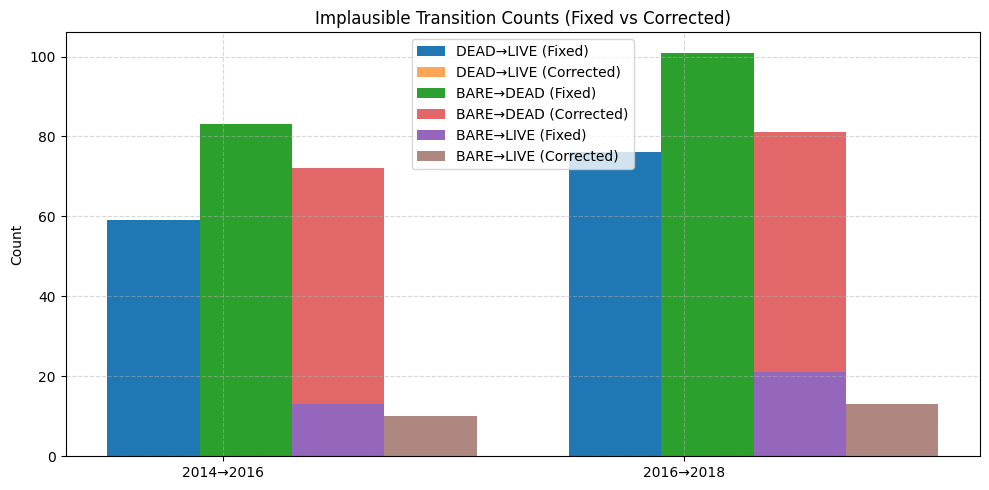

In [7]:
import rasterio
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Config ---
random.seed(42)
YEARS = [2014, 2016, 2018]
RASTER_PATH = "preprocessed_output_{year}/matched_buffer_{year}.tif"
PRED_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
SAMPLES = 1000
PATCH_SIZE = 5
RADIUS = PATCH_SIZE // 2
DRIFT_RANGE = 2

# Class labels
CLASS_NAMES = {0: "LIVE", 1: "DEAD", 2: "BARE"}

# Implausible transitions
IMPLAUSIBLE = {(2, 1), (2, 0), (1, 0)}

# Load predicted class maps
class_maps = {}
for year in YEARS:
    with rasterio.open(PRED_PATH.format(year=year)) as src:
        class_maps[year] = src.read(1)

# Load RGBNIR imagery
rgbnir_maps = {}
for year in YEARS:
    with rasterio.open(RASTER_PATH.format(year=year)) as src:
        rgbnir_maps[year] = src.read([1, 2, 3, 4])

height, width = class_maps[YEARS[0]].shape

# Sample valid pixels
mask = (class_maps[YEARS[0]] <= 2)
pixels = []
while len(pixels) < SAMPLES:
    r = random.randint(RADIUS + DRIFT_RANGE, height - RADIUS - DRIFT_RANGE - 1)
    c = random.randint(RADIUS + DRIFT_RANGE, width - RADIUS - DRIFT_RANGE - 1)
    if mask[r, c]:
        pixels.append((r, c))

# MSE matcher
def best_match(ref_patch, tgt_rgb, r, c):
    min_mse, best_loc = float('inf'), (r, c)
    ref_rgb = ref_patch[:3]
    for dr in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
        for dc in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
            rr, cc = r + dr, c + dc
            if rr - RADIUS < 0 or rr + RADIUS + 1 > height or cc - RADIUS < 0 or cc + RADIUS + 1 > width:
                continue
            candidate = tgt_rgb[:3, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
            mse = np.mean((ref_rgb - candidate) ** 2)
            if mse < min_mse:
                min_mse = mse
                best_loc = (rr, cc)
    return best_loc

# Initialize transition counters
year_pairs = list(zip(YEARS[:-1], YEARS[1:]))
implausible_counts = {pair: {'fixed': 0, 'corrected': 0} for pair in year_pairs}
transition_matrix = {
    pair: {'fixed': defaultdict(int), 'corrected': defaultdict(int)}
    for pair in year_pairs
}

# Analyze transitions
for r, c in tqdm(pixels, desc="Analyzing transitions"):
    rr, cc = r, c
    for (y1, y2) in year_pairs:
        # --- Fixed ---
        a, b = class_maps[y1][r, c], class_maps[y2][r, c]
        if (a, b) in IMPLAUSIBLE:
            implausible_counts[(y1, y2)]['fixed'] += 1
        transition_matrix[(y1, y2)]['fixed'][(a, b)] += 1

        # --- Corrected ---
        ref_patch = rgbnir_maps[y1][:, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
        tgt_rgb = rgbnir_maps[y2]
        rr, cc = best_match(ref_patch, tgt_rgb, rr, cc)
        a_corr = class_maps[y1][r, c]
        b_corr = class_maps[y2][rr, cc]
        if (a_corr, b_corr) in IMPLAUSIBLE:
            implausible_counts[(y1, y2)]['corrected'] += 1
        transition_matrix[(y1, y2)]['corrected'][(a_corr, b_corr)] += 1

# --- Print output matrix ---
for (y1, y2) in year_pairs:
    print(f"\n📆 {y1} → {y2} Transition Summary:")
    f_bad = implausible_counts[(y1, y2)]['fixed']
    c_bad = implausible_counts[(y1, y2)]['corrected']
    print(f"  Fixed     → {f_bad} / {SAMPLES} ({f_bad / SAMPLES:.2%})")
    for (a, b), count in transition_matrix[(y1, y2)]['fixed'].items():
        if (a, b) in IMPLAUSIBLE:
            print(f"    Fixed   {CLASS_NAMES.get(a, a)} → {CLASS_NAMES.get(b, b)}: {count}")
    print(f"  Corrected → {c_bad} / {SAMPLES} ({c_bad / SAMPLES:.2%})")
    for (a, b), count in transition_matrix[(y1, y2)]['corrected'].items():
        if (a, b) in IMPLAUSIBLE:
            print(f"    Correct {CLASS_NAMES.get(a, a)} → {CLASS_NAMES.get(b, b)}: {count}")

# --- Bar chart visualization ---
labels = ["DEAD→LIVE", "BARE→DEAD", "BARE→LIVE"]
x = np.arange(len(year_pairs))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))

for i, label in enumerate(labels):
    a, b = {'DEAD→LIVE': (1, 0), 'BARE→DEAD': (2, 1), 'BARE→LIVE': (2, 0)}[label]
    fixed_vals = [transition_matrix[yp]['fixed'].get((a, b), 0) for yp in year_pairs]
    corr_vals = [transition_matrix[yp]['corrected'].get((a, b), 0) for yp in year_pairs]

    ax.bar(x + i * width - 0.15, fixed_vals, width=width, label=f"{label} (Fixed)")
    ax.bar(x + i * width + 0.05, corr_vals, width=width, label=f"{label} (Corrected)", alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels([f"{a}→{b}" for (a, b) in year_pairs])
ax.set_ylabel("Count")
ax.set_title("Implausible Transition Counts (Fixed vs Corrected)")
ax.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Computing transitions: 100%|██████████| 1000/1000 [00:00<00:00, 4973.80it/s]


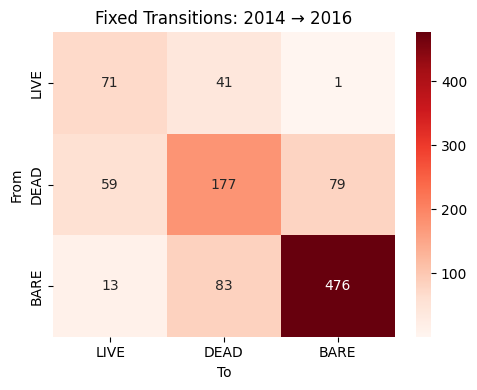

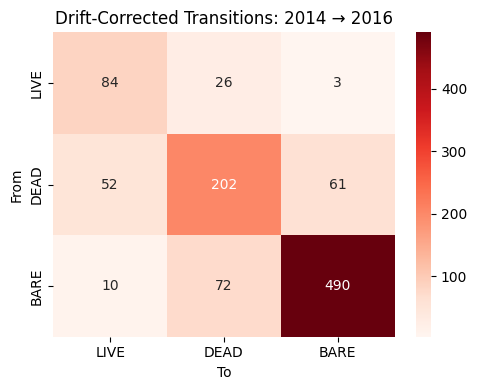

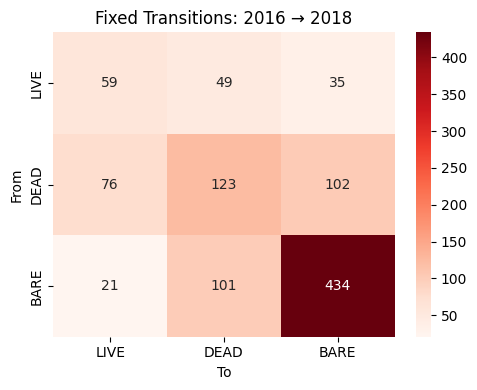

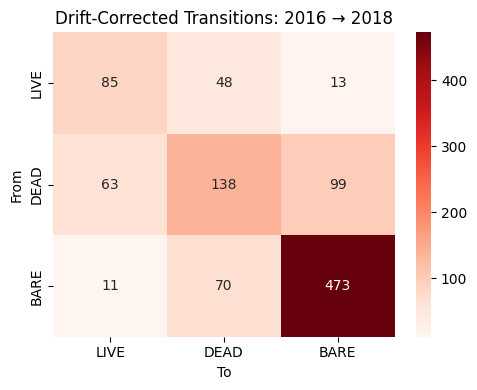

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import random
from tqdm import tqdm
from collections import defaultdict

# === CONFIG ===
random.seed(42)
YEARS = [2014, 2016, 2018]
RASTER_PATH = "preprocessed_output_{year}/matched_buffer_{year}.tif"
PRED_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
SAMPLES = 1000
PATCH_SIZE = 5
RADIUS = PATCH_SIZE // 2
DRIFT_RANGE = 2
LABELS = {0: "LIVE", 1: "DEAD", 2: "BARE"}

# === Load data ===
class_maps = {y: rasterio.open(PRED_PATH.format(year=y)).read(1) for y in YEARS}
rgbnir_maps = {y: rasterio.open(RASTER_PATH.format(year=y)).read([1,2,3,4]) for y in YEARS}
height, width = class_maps[YEARS[0]].shape

# === Sample points ===
mask = class_maps[YEARS[0]] <= 2
pixels = []
while len(pixels) < SAMPLES:
    r = random.randint(RADIUS + DRIFT_RANGE, height - RADIUS - DRIFT_RANGE - 1)
    c = random.randint(RADIUS + DRIFT_RANGE, width - RADIUS - DRIFT_RANGE - 1)
    if mask[r, c]:
        pixels.append((r, c))

# === Helper: MSE matcher ===
def best_match(ref_patch, tgt_img, r, c):
    min_mse, best_rc = float('inf'), (r, c)
    ref_rgb = ref_patch[:3]
    for dr in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
        for dc in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
            rr, cc = r + dr, c + dc
            if rr - RADIUS < 0 or rr + RADIUS + 1 > height or cc - RADIUS < 0 or cc + RADIUS + 1 > width:
                continue
            cand = tgt_img[:3, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
            mse = np.mean((ref_rgb - cand) ** 2)
            if mse < min_mse:
                min_mse = mse
                best_rc = (rr, cc)
    return best_rc

# === Count transitions ===
fixed_transitions = defaultdict(int)
corrected_transitions = defaultdict(int)

for r, c in tqdm(pixels, desc="Computing transitions"):
    # --- Fixed ---
    seq = [class_maps[y][r, c] for y in YEARS]
    for i in range(len(seq) - 1):
        fixed_transitions[(YEARS[i], seq[i], seq[i+1])] += 1

    # --- Corrected ---
    rr, cc = r, c
    seq_corr = [class_maps[YEARS[0]][rr, cc]]
    for i in range(len(YEARS) - 1):
        ref_patch = rgbnir_maps[YEARS[i]][:, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
        tgt_img = rgbnir_maps[YEARS[i + 1]]
        rr, cc = best_match(ref_patch, tgt_img, rr, cc)
        seq_corr.append(class_maps[YEARS[i + 1]][rr, cc])
    for i in range(len(seq_corr) - 1):
        corrected_transitions[(YEARS[i], seq_corr[i], seq_corr[i+1])] += 1

# === Plot heatmaps ===
def plot_heatmap(matrix, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Reds', xticklabels=["LIVE", "DEAD", "BARE"], yticklabels=["LIVE", "DEAD", "BARE"])
    plt.title(title)
    plt.xlabel("To")
    plt.ylabel("From")
    plt.tight_layout()
    plt.show()

for i in range(len(YEARS)-1):
    y1, y2 = YEARS[i], YEARS[i+1]

    mat_fixed = np.zeros((3, 3), dtype=int)
    mat_corr = np.zeros((3, 3), dtype=int)

    for f in range(3):
        for t in range(3):
            mat_fixed[f, t] = fixed_transitions.get((y1, f, t), 0)
            mat_corr[f, t] = corrected_transitions.get((y1, f, t), 0)

    plot_heatmap(mat_fixed, f"Fixed Transitions: {y1} → {y2}")
    plot_heatmap(mat_corr, f"Drift-Corrected Transitions: {y1} → {y2}")

In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# === CONFIG ===
YEARS = [2014, 2016, 2018]
RASTER_PATH = "preprocessed_output_{year}/matched_buffer_{year}.tif"
PRED_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
PATCH_SIZE = 5
RADIUS = PATCH_SIZE // 2
DRIFT_RANGE = 2

LABELS = {0: "LIVE", 1: "DEAD", 2: "BARE"}
IMPLAUSIBLE = {(2, 0), (2, 1), (1, 0)}

# === Load maps
class_maps = {y: rasterio.open(PRED_PATH.format(year=y)).read(1) for y in YEARS}
rgbnir_maps = {y: rasterio.open(RASTER_PATH.format(year=y)).read([1, 2, 3, 4]) for y in YEARS}
height, width = class_maps[YEARS[0]].shape
valid_mask = class_maps[YEARS[0]] <= 2

# === MSE Patch Matching with Bound Checks
def best_match(ref_patch, tgt_img, r, c):
    min_mse, best_loc = float('inf'), (r, c)
    ref_rgb = ref_patch[:3]
    for dr in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
        for dc in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
            rr, cc = r + dr, c + dc
            if (rr - RADIUS < 0 or rr + RADIUS + 1 > height or
                cc - RADIUS < 0 or cc + RADIUS + 1 > width):
                continue
            candidate = tgt_img[:3, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
            if candidate.shape != ref_rgb.shape:
                continue
            mse = np.mean((ref_rgb - candidate) ** 2)
            if mse < min_mse:
                min_mse = mse
                best_loc = (rr, cc)
    return best_loc

# === Transition Analysis
fixed_counts = defaultdict(int)
corrected_counts = defaultdict(int)
implaus_fixed = 0
implaus_corr = 0

rows, cols = np.where(valid_mask)
for r, c in tqdm(zip(rows, cols), total=len(rows), desc="Evaluating raster"):
    if (r - RADIUS < 0 or r + RADIUS + 1 > height or
        c - RADIUS < 0 or c + RADIUS + 1 > width):
        continue

    # Fixed
    seq_fixed = [class_maps[y][r, c] for y in YEARS]
    for i in range(len(YEARS) - 1):
        a, b = seq_fixed[i], seq_fixed[i + 1]
        fixed_counts[(YEARS[i], a, b)] += 1
        if (a, b) in IMPLAUSIBLE:
            implaus_fixed += 1

    # Corrected
    rr, cc = r, c
    seq_corr = [class_maps[YEARS[0]][rr, cc]]
    for i in range(len(YEARS) - 1):
        ref_patch = rgbnir_maps[YEARS[i]][:, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
        tgt_rgb = rgbnir_maps[YEARS[i + 1]]
        rr, cc = best_match(ref_patch, tgt_rgb, rr, cc)
        if rr < 0 or rr >= height or cc < 0 or cc >= width:
            break  # out of bounds
        to_class = class_maps[YEARS[i + 1]][rr, cc]
        corrected_counts[(YEARS[i], seq_corr[-1], to_class)] += 1
        if (seq_corr[-1], to_class) in IMPLAUSIBLE:
            implaus_corr += 1
        seq_corr.append(to_class)

# === Report
print(f"\n🚨 Implausible Transitions Summary:")
print(f"Fixed     → {implaus_fixed}")
print(f"Corrected → {implaus_corr}\n")

for i in range(len(YEARS) - 1):
    y1, y2 = YEARS[i], YEARS[i + 1]
    print(f"🔁 Transitions {y1} → {y2} (Fixed vs Corrected):")
    for a in range(3):
        for b in range(3):
            label = f"{LABELS[a]} → {LABELS[b]}"
            fval = fixed_counts.get((y1, a, b), 0)
            cval = corrected_counts.get((y1, a, b), 0)
            print(f"  {label:<16}: {fval:>6} (F), {cval:>6} (C)")
    print()

Evaluating raster: 100%|██████████| 125629/125629 [00:27<00:00, 4612.31it/s]


🚨 Implausible Transitions Summary:
Fixed     → 42562
Corrected → 35737

🔁 Transitions 2014 → 2016 (Fixed vs Corrected):
  LIVE → LIVE     :   8618 (F),   9373 (C)
  LIVE → DEAD     :   5021 (F),   4378 (C)
  LIVE → BARE     :    375 (F),    262 (C)
  DEAD → LIVE     :   6998 (F),   7231 (C)
  DEAD → DEAD     :  23817 (F),  25827 (C)
  DEAD → BARE     :  10543 (F),   8271 (C)
  BARE → LIVE     :   1911 (F),    999 (C)
  BARE → DEAD     :   9984 (F),   8549 (C)
  BARE → BARE     :  58202 (F),  60548 (C)

🔁 Transitions 2016 → 2018 (Fixed vs Corrected):
  LIVE → LIVE     :   6951 (F),   9011 (C)
  LIVE → DEAD     :   6306 (F),   6536 (C)
  LIVE → BARE     :   4270 (F),   2056 (C)
  DEAD → LIVE     :   9550 (F),   8398 (C)
  DEAD → DEAD     :  15683 (F),  19308 (C)
  DEAD → BARE     :  13586 (F),  11048 (C)
  BARE → LIVE     :   2292 (F),   1920 (C)
  BARE → DEAD     :  11827 (F),   8640 (C)
  BARE → BARE     :  55001 (F),  58521 (C)



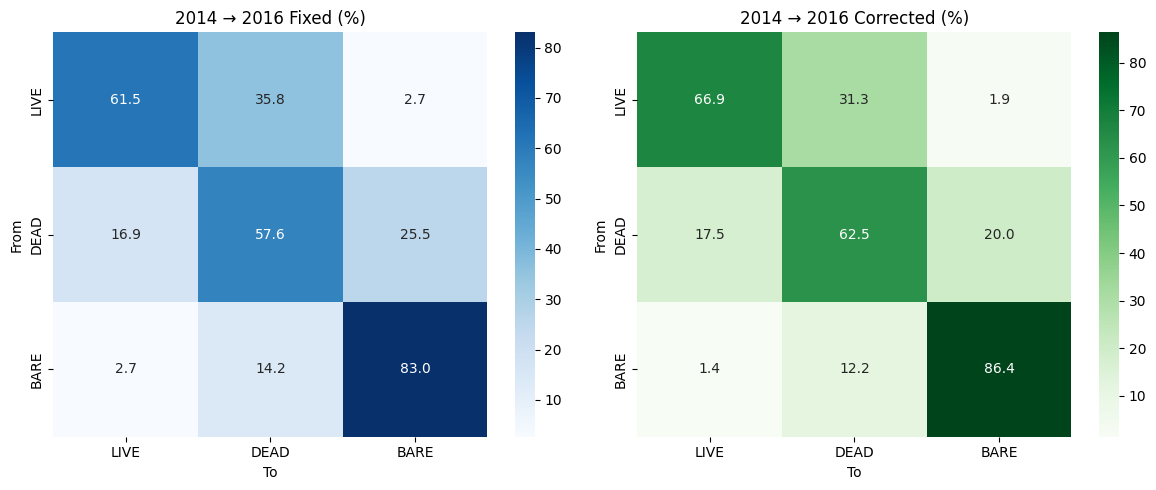

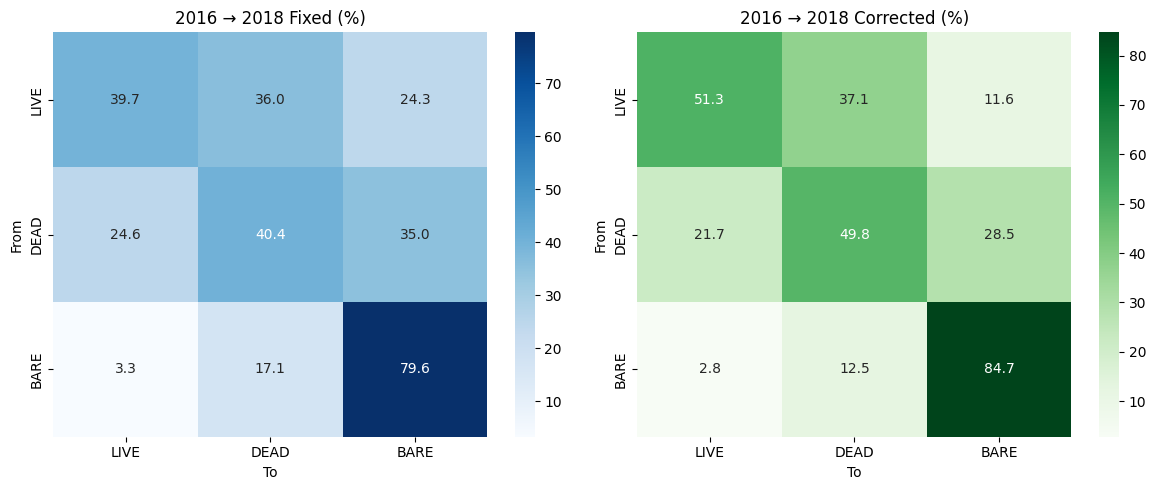

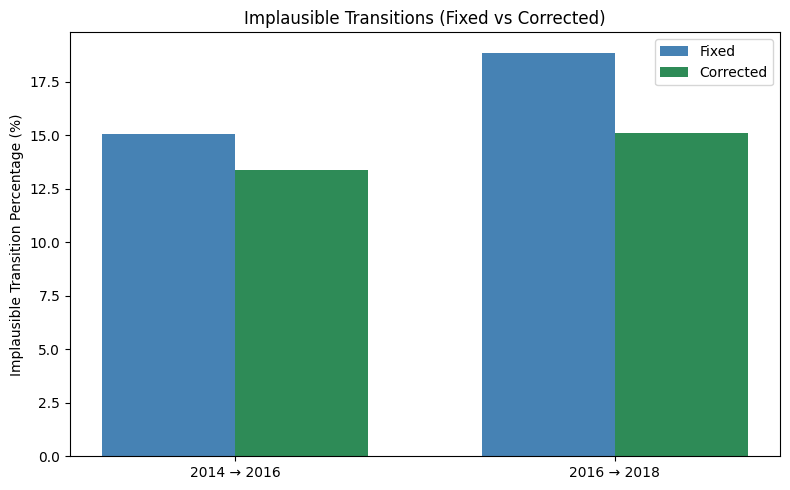

In [4]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- Config ---
YEARS = [2014, 2016, 2018]
RASTER_PATH = "preprocessed_output_{year}/matched_buffer_{year}.tif"
PRED_PATH = "predicted_rasters/predicted_class_map_{year}.tif"
PATCH_SIZE = 5
RADIUS = PATCH_SIZE // 2
DRIFT_RANGE = 2  # 5×5 search

# --- Load data ---
class_maps = {y: rasterio.open(PRED_PATH.format(year=y)).read(1) for y in YEARS}
rgbnir_maps = {y: rasterio.open(RASTER_PATH.format(year=y)).read([1, 2, 3, 4]) for y in YEARS}

h, w = class_maps[YEARS[0]].shape
valid_mask = (class_maps[YEARS[0]] <= 2)

# --- Best match finder ---
def best_match(ref_patch, tgt_rgb, r, c):
    best, min_mse = (r, c), float("inf")
    ref_rgb = ref_patch[:3]
    for dr in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
        for dc in range(-DRIFT_RANGE, DRIFT_RANGE + 1):
            rr, cc = r + dr, c + dc
            if rr - RADIUS < 0 or rr + RADIUS + 1 > h or cc - RADIUS < 0 or cc + RADIUS + 1 > w:
                continue
            cand = tgt_rgb[:3, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
            mse = np.mean((ref_rgb - cand) ** 2)
            if mse < min_mse:
                best, min_mse = (rr, cc), mse
    return best

# --- Transition counters ---
transition_counts_fixed_2014_2016 = Counter()
transition_counts_corrected_2014_2016 = Counter()
transition_counts_fixed_2016_2018 = Counter()
transition_counts_corrected_2016_2018 = Counter()

for r in range(RADIUS + DRIFT_RANGE, h - RADIUS - DRIFT_RANGE):
    for c in range(RADIUS + DRIFT_RANGE, w - RADIUS - DRIFT_RANGE):
        if not valid_mask[r, c]:
            continue

        # === Fixed transitions
        a_2014 = class_maps[2014][r, c]
        b_2016 = class_maps[2016][r, c]
        c_2018 = class_maps[2018][r, c]
        transition_counts_fixed_2014_2016[(a_2014, b_2016)] += 1
        transition_counts_fixed_2016_2018[(b_2016, c_2018)] += 1

        # === Corrected transitions
        rr, cc = r, c
        ref_2014 = rgbnir_maps[2014][:, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
        rr, cc = best_match(ref_2014, rgbnir_maps[2016], rr, cc)
        a_corr_2016 = class_maps[2016][rr, cc]
        transition_counts_corrected_2014_2016[(a_2014, a_corr_2016)] += 1

        ref_2016 = rgbnir_maps[2016][:, rr - RADIUS:rr + RADIUS + 1, cc - RADIUS:cc + RADIUS + 1]
        rr, cc = best_match(ref_2016, rgbnir_maps[2018], rr, cc)
        a_corr_2018 = class_maps[2018][rr, cc]
        transition_counts_corrected_2016_2018[(a_corr_2016, a_corr_2018)] += 1

# --- Class mapping
class_names = {0: 'LIVE', 1: 'DEAD', 2: 'BARE'}
classes = [0, 1, 2]

def make_matrix(count_dict):
    mat = np.zeros((3, 3), dtype=int)
    for (f, t), count in count_dict.items():
        if f in classes and t in classes:
            mat[f, t] = count
    return mat

def plot_heatmaps(fixed_mat, corr_mat, title):
    # Convert to percentages (row-wise)
    fixed_pct = 100 * fixed_mat / fixed_mat.sum(axis=1, keepdims=True)
    corr_pct = 100 * corr_mat / corr_mat.sum(axis=1, keepdims=True)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(fixed_pct, annot=True, fmt='.1f', cmap="Blues", ax=axs[0],
                xticklabels=class_names.values(), yticklabels=class_names.values())
    axs[0].set_title(f"{title} Fixed (%)")
    axs[0].set_xlabel("To")
    axs[0].set_ylabel("From")

    sns.heatmap(corr_pct, annot=True, fmt='.1f', cmap="Greens", ax=axs[1],
                xticklabels=class_names.values(), yticklabels=class_names.values())
    axs[1].set_title(f"{title} Corrected (%)")
    axs[1].set_xlabel("To")
    axs[1].set_ylabel("From")

    plt.tight_layout()
    plt.show()

# --- Matrices and plots
m_f_14_16 = make_matrix(transition_counts_fixed_2014_2016)
m_c_14_16 = make_matrix(transition_counts_corrected_2014_2016)
m_f_16_18 = make_matrix(transition_counts_fixed_2016_2018)
m_c_16_18 = make_matrix(transition_counts_corrected_2016_2018)

plot_heatmaps(m_f_14_16, m_c_14_16, "2014 → 2016")
plot_heatmaps(m_f_16_18, m_c_16_18, "2016 → 2018")

# --- Bar plot for total implausible transitions (percentage) ---
years = ['2014 → 2016', '2016 → 2018']
totals_fixed = [sum(m_f_14_16[i][j] for i, j in IMPLAUSIBLE), sum(m_f_16_18[i][j] for i, j in IMPLAUSIBLE)]
totals_corr = [sum(m_c_14_16[i][j] for i, j in IMPLAUSIBLE), sum(m_c_16_18[i][j] for i, j in IMPLAUSIBLE)]

# Calculate total transitions for each period to get percentages
total_transitions_fixed = [np.sum(m_f_14_16), np.sum(m_f_16_18)]
total_transitions_corr = [np.sum(m_c_14_16), np.sum(m_c_16_18)]

# Convert to percentages
pct_fixed = [100 * totals_fixed[i] / total_transitions_fixed[i] for i in range(len(years))]
pct_corr = [100 * totals_corr[i] / total_transitions_corr[i] for i in range(len(years))]

x = np.arange(len(years))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, pct_fixed, width, label="Fixed", color="steelblue")
plt.bar(x + width/2, pct_corr, width, label="Corrected", color="seagreen")
plt.xticks(x, years)
plt.ylabel("Implausible Transition Percentage (%)")
plt.title("Implausible Transitions (Fixed vs Corrected)")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import numpy as np
from scipy.stats import chi2_contingency

# Construct contingency table
# Rows: Fixed vs Corrected
# Columns: Implausible vs Plausible
table = np.array([
    [18812, 129992 - 18812],  # Fixed: implausible, plausible
    [16709, 129992 - 16709],  # Corrected: implausible, plausible
])

# Run chi-squared test
chi2, p, dof, expected = chi2_contingency(table)

print(f"Chi² Statistic: {chi2:.4f}")
print(f"P-value: {p:.6f}")

Chi² Statistic: 144.0728
P-value: 0.000000
